Cp correction being accounted

In [1]:
from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib.pyplot as plt

''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value.'''

def universal_func(So=2000, Fo=50, mm_dry = 0.028, assumption = 'WTG', p_guess=(250,250,200,200,200,20)):
    g = 13.7 #m/s^2 #gravity
    Pc = 6e4
    Po = 1.01e5
    R_star = 8.3145
    k3 = 0.08 # relates the strength of convection to the cloud fraction
    #fc = 0
    def equations(p): 
        T1, T2, T3, T4, Fa, Fc = p 

        ### Constants
        es0 = 611.2
        M = 0.018
        To = 273.15
        mass_ratio = M/mm_dry

        sigma = 5.67e-8 #W /m^2 K^4  Stefan Boltzmann Constant
        
        H = ((R_star/mm_dry)*T2)/g #scale height
        
        Tc = 230 #Cloud emission temp
        Z_a = np.log(Po/Pc)*H #convection height
        Cpd = 1005.7 #J/kgK #heat capacity
        Cpv = 1996 #J/kgK #heat capacity
        L = 2.501e6 # J/kg #latent heat of vaporization

        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1))
        w_1 = mass_ratio*es_1/(Po - es_1) #saturated mixing ratio
        q1_s = w_1/(1+w_1)

        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        w_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        q2_s = w_2/(1+w_2)
        
        es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
        w_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
        q3_s = w_3/(1+w_3)

        RH_1 = 0.9 #Relative Humidity
        RH_2 = 0.8 
        RH_3 = 0.3
        
        q1 = RH_1 * q1_s
        q2 = RH_2 * q2_s #specific humidity
        q3 = RH_3 * q3_s #specific humidity
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1
        Cp2 = Cpd*(1 - q2) + Cpv * q2

        #So = 2000 # W/m^2 Solar insolation
        #Fo' = 0 # Ocean heat transport

        
        k1 = 0.2 # Fraction of heat transport to the nightside deposited in the boundary layer
        k2 = 1000 # Relates water vapor to the infrared opacity 
        #k3 = 0.08 # relates the strength of convection to the cloud fraction
        Fd = k1*Fa
        
        fc = k3*np.log(Fc+1.0)
        
        alpha_p = 0.09+fc - 0.09*fc # planetary albedo
        
        def Tv(T,mass_ratio,w):
            Tv = T*((1 + (w/mass_ratio))/(1+w)) # w is the water vapor mixing ratio
            return Tv

        epsilon_2 = 1 - np.exp(-k2*q2) #emissivity
        epsilon_3 = 1 - np.exp(-k2*q3)

        Eq2 = (1/2)*So*(1-alpha_p)-Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

        Eq3 = Fc - Fa + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

        Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

        Eq5 = Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        Eq6_WTG = T2 - T3

        Eq6_WBG = Tv(T2,mass_ratio,(q2/(1-q2))) - Tv(T3,mass_ratio,(q3/(1-q3)))

        Eq7_WTG = Cp1*T1 + L*q1_s - (Cp2*T2+L*q2_s + g*Z_a)
        Eq7_WBG = Cp1*Tv(T1,mass_ratio,(q1/(1-q1))) + L*q1_s - (Cp2*Tv(T2,mass_ratio,(q2/(1-q2)))+L*q2_s + g*Z_a)
        
        OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4
        OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3*sigma*T3**4
        
        if assumption == 'WTG': 
            Eq6 = Eq6_WTG
            Eq7 = Eq7_WTG
        elif assumption == 'WBG':
            Eq6  = Eq6_WBG
            Eq7 = Eq7_WBG
        if index==0:
            return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        if index==1:
            return(q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day, OLR_night)
        
    index=0
    T1, T2, T3, T4, Fa, Fc = fsolve(equations,p_guess)       
    #fc_2 = fc
    fc_2 = k3*np.log(Fc+1.0)
    if fc_2 >=1:
        print('cloud fraction: ',fc_2)
    index=1
    q1,q2,q3,alpha_p,epsilon_2,epsilon_3, OLR_day, OLR_night = equations((T1, T2, T3, T4, Fa, Fc))   
    return (T1, T2, T3, T4, Fa, Fc, fc_2,
            q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day, OLR_night )

In [2]:
universal_func(So=2500, assumption='WTG')

(296.22780819264324,
 278.314152838135,
 278.314152838135,
 295.0399419947316,
 295.3511425587698,
 367.4422298684902,
 0.4727427142632522,
 0.016569045617379884,
 0.007607795456421831,
 0.0028529232961581868,
 0.5201958699795595,
 0.9995034346473339,
 0.9423245282878496,
 254.404019964682,
 345.35114251674605)

In [3]:
so = np.linspace(1000,4500,100)
nele = len(so)
T1_arr_WBG, T2_arr_WBG, T3_arr_WBG, T4_arr_WBG, Fa_arr_WBG, Fc_arr_WBG, fc_arr_WBG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG, OLR_day_arr_WBG, OLR_night_arr_WBG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele)

initial_guess = (250,250,200,200,200,20)
for idx,s in enumerate(so):
    T1_arr_WBG[idx], T2_arr_WBG[idx], T3_arr_WBG[idx], T4_arr_WBG[idx], Fa_arr_WBG[idx], Fc_arr_WBG[idx], fc_arr_WBG[idx], \
    q1_arr_WBG[idx],q2_arr_WBG[idx],q3_arr_WBG[idx],alpha_p_arr_WBG[idx],epsilon_2_arr_WBG[idx],epsilon_3_arr_WBG[idx], OLR_day_arr_WBG[idx], OLR_night_arr_WBG[idx] = universal_func(So = s, assumption  = 'WBG', p_guess = initial_guess)
    initial_guess = (T1_arr_WBG[idx], T2_arr_WBG[idx], T3_arr_WBG[idx], T4_arr_WBG[idx], Fa_arr_WBG[idx], Fc_arr_WBG[idx])
    
    
#print(np.where(1 <= epsilon_3_arr_WBG))
#print(epsilon_3_arr_WBG[50:52])

In [4]:
so = np.linspace(1000,4500,100)
nele = len(so)
T1_arr_WTG, T2_arr_WTG, T3_arr_WTG, T4_arr_WTG, Fa_arr_WTG, Fc_arr_WTG, fc_arr_WTG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG, OLR_day_arr_WTG, OLR_night_arr_WTG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

initial_guess = (250,250,200,200,200,20)
for idx,s in enumerate(so):
    T1_arr_WTG[idx], T2_arr_WTG[idx], T3_arr_WTG[idx], T4_arr_WTG[idx], Fa_arr_WTG[idx], Fc_arr_WTG[idx], fc_arr_WTG[idx], \
    q1_arr_WTG[idx],q2_arr_WTG[idx],q3_arr_WTG[idx],alpha_p_arr_WTG[idx],epsilon_2_arr_WTG[idx],epsilon_3_arr_WTG[idx], OLR_day_arr_WTG[idx], OLR_night_arr_WTG[idx] = universal_func(So = s, assumption  = 'WTG', p_guess = initial_guess)
    initial_guess = (T1_arr_WTG[idx], T2_arr_WTG[idx], T3_arr_WTG[idx], T4_arr_WTG[idx], Fa_arr_WTG[idx], Fc_arr_WTG[idx])

In [5]:
def plot_diff(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    fig = plt.figure(figsize = (12,10))
    plt.suptitle('WBG - WTG', fontsize = 16)
    #arr_list_WBG = [q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,fc_arr_WBG]
    #arr_list_WTG = [q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,fc_arr_WTG]
    #arr_list_WBG = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
    #arr_list_WTG = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
    #arr_list_WBG = [Fa_arr_WBG, Fc_arr_WBG, alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG]
    arr_list = [Fa_arr_WTG, Fc_arr_WTG, alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG]
    #arr_list = [arr_list_WBG[idx] - arr_list_WTG[idx] for idx in range(4) ]

    nele = len(arr_list)
    #name_list = ['q1','q2','q3','fc']
    #unit_list = [r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$']
    #name_list = ['T1','T2','T3','T4']
    #unit_list = ['K','K','K','K']
    name_list = ['Fa','Fc',r'$\alpha_p$',r'$\epsilon_2$',r'$\epsilon_3$',r'$f_c$']
    unit_list = [r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$','','', '','']
    
    if nele % 2 == 0:
        nrows = (nele)//2
    else:
        nrows = (nele)//2+1, 
    ncols = 2
    print(np.shape(arr_list))

    for idx, arr in enumerate(arr_list):
        ax  =plt.subplot(nrows, ncols, idx + 1)

        ax.plot(so, arr, color = 'k', markersize = 9, label = 'WBG-WTG')
        #ax.set_title(assumption)
        ax.set_xlabel(xlab +'('+ xunit +')')
        ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
        plt.xlim(1000,3000)
        #plt.ylim(160,320)
        if idx ==3: 
            plt.legend(frameon = False)
    plt.savefig("WTG_WBG_diff_T1-T4.png")
    plt.close()

    return fig
plot_diff(so)

(5, 100)


ValueError: Number of rows must be a positive integer, not (3,)

<Figure size 864x720 with 0 Axes>

(4, 100)
(4, 100)


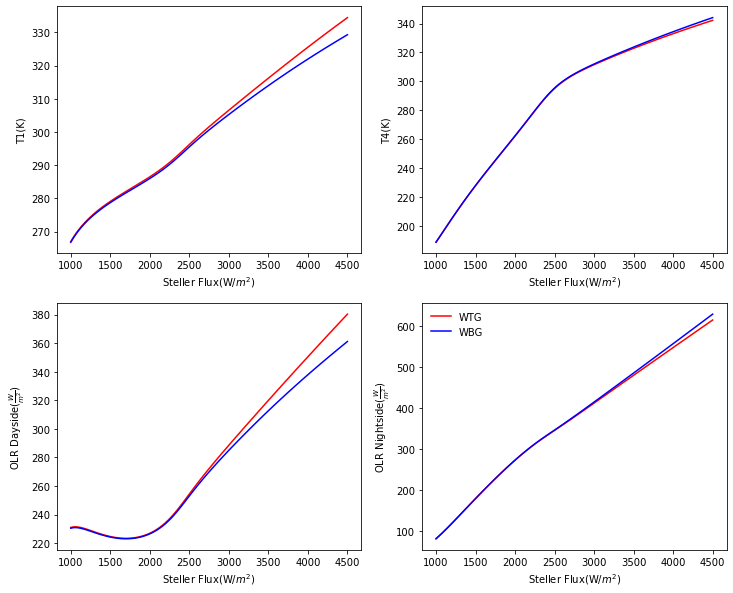

In [7]:
def plot_across_so(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    fig = plt.figure(figsize = (12,10))
    for i_assump, (assumption, my_color) in enumerate(zip(['WTG','WBG'], ['r','b'])):
        if assumption == 'WBG':
            #arr_list = [q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,fc_arr_WBG]
            #arr_list = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
            #arr_list = [Fa_arr_WBG, Fc_arr_WBG, alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG,fc_arr_WBG ]
            arr_list = [T1_arr_WBG, T4_arr_WBG, OLR_day_arr_WBG, OLR_night_arr_WBG]
        elif assumption == 'WTG':
            #arr_list = [q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,fc_arr_WTG]
            #arr_list = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
            #arr_list = [Fa_arr_WTG, Fc_arr_WTG, alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG,fc_arr_WTG]
            arr_list = [T1_arr_WTG, T4_arr_WTG, OLR_day_arr_WTG, OLR_night_arr_WTG]
        
        nele = len(arr_list)
        #name_list = ['T1','T2','T3','T4']
        #unit_list = ['K','K','K','K']
        #name_list = ['q1','q2','q3','fc']
        #unit_list = [r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$']
        #name_list = ['Fa','Fc',r'$\alpha_p$',r'$\epsilon_2$',r'$\epsilon_3$',r'$f_c$']
        #unit_list = [r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$','','', '','']
        name_list = ['T1','T4', 'OLR Dayside', 'OLR Nightside']
        unit_list = ['K', 'K', r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$']
        
        
        if nele % 2 == 0:
            nrows = (nele)//2
        else:
            nrows = (nele)//2+1
        ncols = 2
        print(np.shape(arr_list))

        for idx, arr in enumerate(arr_list):
            ax  =plt.subplot(nrows, ncols, idx + 1)

            ax.plot(so, arr, color = my_color, markersize = 9, label = assumption)

            #ax.set_title(assumption)
            ax.set_xlabel(xlab +'('+ xunit +')')
            ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
            #plt.xlim(1000,3000)
            #plt.ylim(160,320)
            if idx ==3: 
                plt.legend(frameon = False)
    plt.savefig("WTG_WBG_compare_T1-T4_cp_correction.png")
    plt.close()

    return fig

plot_across_so(so)

### plotting

(4, 100)
(4, 100)


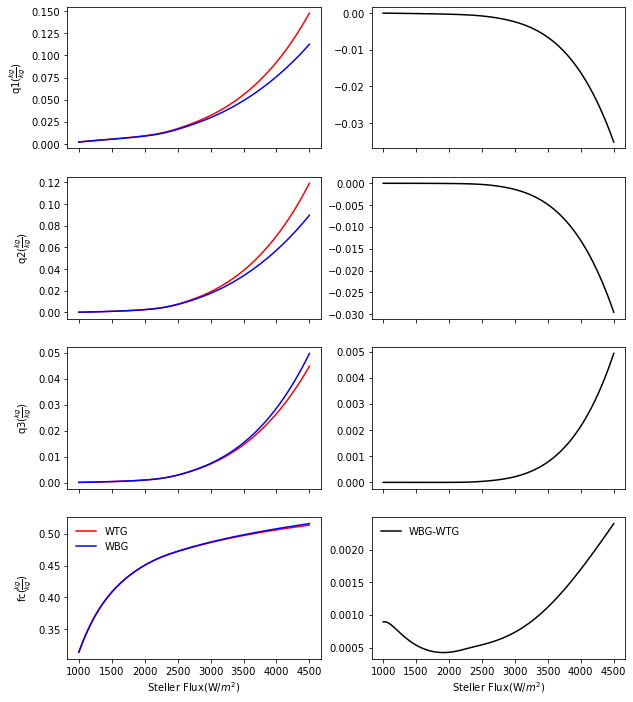

In [27]:
def plot_8panels(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
   
    
    
    arr_list_WBG = [q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,fc_arr_WBG]
    arr_list_WTG = [q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,fc_arr_WTG]
    #arr_list_WBG = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
    #arr_list_WTG = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
    #arr_list_WBG = [Fa_arr_WBG, Fc_arr_WBG, alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG]
    #arr_list_WTG = [Fa_arr_WTG, Fc_arr_WTG, alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG]
    #arr_list_WTG = [OLR_day_arr_WTG, OLR_night_arr_WTG]
    #arr_list_WBG  = [OLR_day_arr_WBG, OLR_night_arr_WBG]
    #arr_list_WBG = [T1_arr_WBG,]
    
    
    #name_list = ['T1','T2','T3','T4']
    #unit_list = ['K','K','K','K']
    name_list = ['q1','q2','q3','fc']
    unit_list = [r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$']
    #name_list = ['Fa','Fc',r'$\alpha_p$',r'$\epsilon_2$',r'$\epsilon_3$']
    #unit_list = [r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$','','', '']
    #name_list = ['OLR_day', 'OLR_night']
    #unit_list = [r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$']
    
    nele = len(name_list)
    ncols = 2
    nrows = nele
    fig, axs = plt.subplots(nrows, ncols, sharex = True, figsize = (10,12))
    ax = axs[0][0]
    
    #nele = len(arr_list)
    #name_list = ['T1','T2','T3','T4']
    #unit_list = ['K','K','K','K']
    
    for i_assump, (assumption, my_color) in enumerate(zip(['WTG','WBG'], ['r','b'])):
        if assumption == 'WBG':
            arr_list = arr_list_WBG
        elif assumption == 'WTG':
            arr_list = arr_list_WTG
        
        print(np.shape(arr_list))

        for idx, arr in enumerate(arr_list):
            ax = axs[idx][0]

            ax.plot(so, arr, color = my_color, markersize = 9, label = assumption)

            #ax.set_title(assumption)
            #ax.set_xlabel(xlab +'('+ xunit +')')
            ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
            #plt.xlim(1000,3000)
            #plt.ylim(50,350)
            if idx == nele - 1: 
                ax.legend(frameon = False)
                ax.set_xlabel(xlab +'('+ xunit +')')
    
    
    ### plot difference
    #plt.suptitle('WBG - WTG', fontsize = 16)

    
    arr_list = [arr_list_WBG[idx] - arr_list_WTG[idx] for idx in range(nele) ]

    for idx, arr in enumerate(arr_list):
        ax = axs[idx][1]
        ax.plot(so, arr, color = 'k', markersize = 9, label = 'WBG-WTG')
        #ax.set_title(assumption)
        
        #ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
        #plt.xlim(1000,3000)
        #plt.ylim(50,350)
        if idx == nele -1: 
            plt.legend(frameon = False)
            plt.xlabel(xlab +'('+ xunit +')')
            
    #axs[0][0].set_ylim(50,350)
    plt.savefig("WTG_WBG_q1-q3.png")
    plt.close()
    
    #fig, axs = plt.subplots(nrows, ncols, sharex = True, figsize = (10,12))
        
        
    

    return fig
plot_8panels(so)

In [ ]:
fig = plt.figure(figsize =(12,6))
plt.rcParams['savefig.facecolor']='white'

for i_assumption, assumption in enumerate(['WTG','WBG']): 
    ax = plt.subplot(1,2,1+i_assumption)
    ax.set_title(assumption)
    
    arr_list_WBG = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
    arr_list_WTG = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
    
    if assumption == 'WBG':
        arr_list = arr_list_WBG
        epsilon_arr = epsilon_2_arr_WBG
    elif assumption == 'WTG': 
        arr_list = arr_list_WTG
        epsilon_arr = epsilon_2_arr_WTG
    
    ax.plot(so, arr_list[0], color = 'r', linestyle = '-', label = 'T1')
    ax.plot(so, arr_list[1], color = 'b', linestyle = '-', label = 'T2')
    ax.plot(so, arr_list[2], color = 'b', linestyle = '--', label = 'T3')
    ax.plot(so, arr_list[3], color = 'r', linestyle = '--', label = 'T4')
    
    transition_point = np.min(np.argwhere(1 <= epsilon_arr))
    print(transition_point)
    ax.scatter(so[transition_point], arr_list[0][transition_point], marker = '*', s = 60, color=  'k')
    
    transition_point = np.min(np.argwhere(1 <= epsilon_arr))
    print(transition_point)
    ax.scatter(so[transition_point], arr_list[0][transition_point], marker = '*', s = 60, color=  'k', label = r'$\epsilon_2 = 1$')
    if i_assumption == 1:
        ax.legend(frameon = False)
    plt.xlabel('Steller Flux' +'(W/m^2)')
    plt.xlim(1000,3000)
    plt.savefig('WTG_WBG_eps2.png', facecolor=fig.get_facecolor(), transparent=False)
